# Phase 2 Results Exploration

Explore Phase 2 analysis results:
- Run stability (how similar across runs?)
- Retention (do gentags preserve meaning?)
- Compression efficiency
- Surface vs semantic similarity

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

TABLES_DIR = Path("../results/phase2/tables")
print("📊 Phase 2 Explorer")

📊 Phase 2 Explorer


In [4]:
# Load tables
run_stability = pd.read_csv(TABLES_DIR / "run_stability.csv")
retention = pd.read_csv(TABLES_DIR / "retention.csv")
compression_summary = pd.read_csv(TABLES_DIR / "compression_summary.csv")
prompt_sensitivity = pd.read_csv(TABLES_DIR / "prompt_sensitivity.csv")
model_sensitivity = pd.read_csv(TABLES_DIR / "model_sensitivity.csv")

print(f"✅ Loaded {len(run_stability)} run stability comparisons")
print(f"✅ Loaded {len(retention)} retention measurements")

✅ Loaded 6636 run stability comparisons
✅ Loaded 13272 retention measurements


In [5]:
# Quick stats
print("RUN STABILITY:")
print(f"Mean cosine: {run_stability['cosine_similarity'].mean():.3f}")
print(run_stability.groupby('model_key')['cosine_similarity'].mean())
print("\nRETENTION:")
print(f"Mean: {retention['retention_cosine'].mean():.3f}")
print(f"Delta vs random: {retention['delta_retention'].mean():.3f}")
print(f"% above random: {(retention['retention_cosine'] > retention['retention_random']).mean() * 100:.1f}%")

RUN STABILITY:
Mean cosine: 0.760
model_key
claude    0.477921
gemini    0.965616
grok      0.625506
openai    0.970504
Name: cosine_similarity, dtype: float64

RETENTION:
Mean: 0.490
Delta vs random: 0.131
% above random: 78.2%


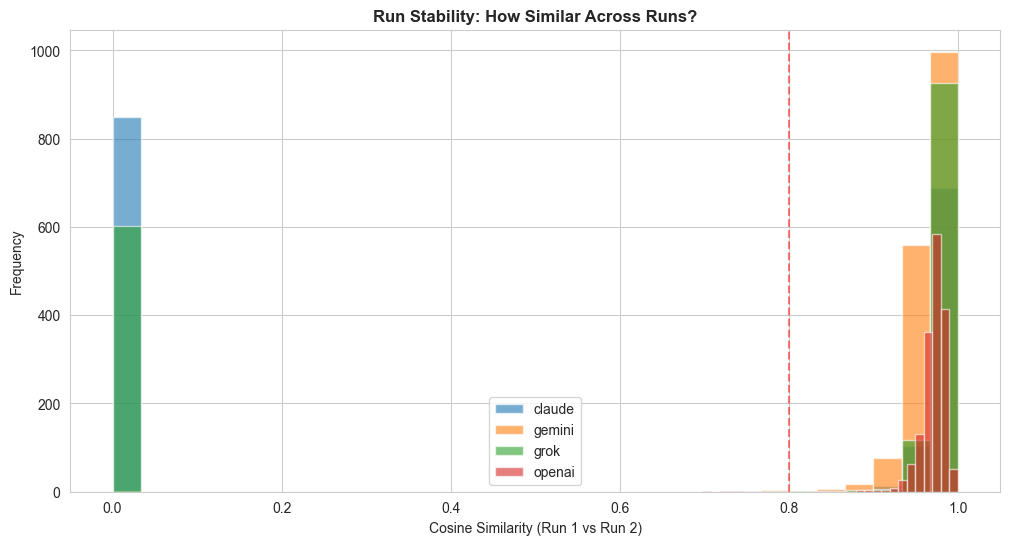

In [6]:
# Run stability by model
fig, ax = plt.subplots(figsize=(12, 6))
for model in run_stability['model_key'].unique():
    data = run_stability[run_stability['model_key'] == model]['cosine_similarity']
    ax.hist(data, alpha=0.6, label=model, bins=30)
ax.set_xlabel('Cosine Similarity (Run 1 vs Run 2)')
ax.set_ylabel('Frequency')
ax.set_title('Run Stability: How Similar Across Runs?', fontweight='bold')
ax.legend()
ax.axvline(0.8, color='red', linestyle='--', alpha=0.5)
plt.show()

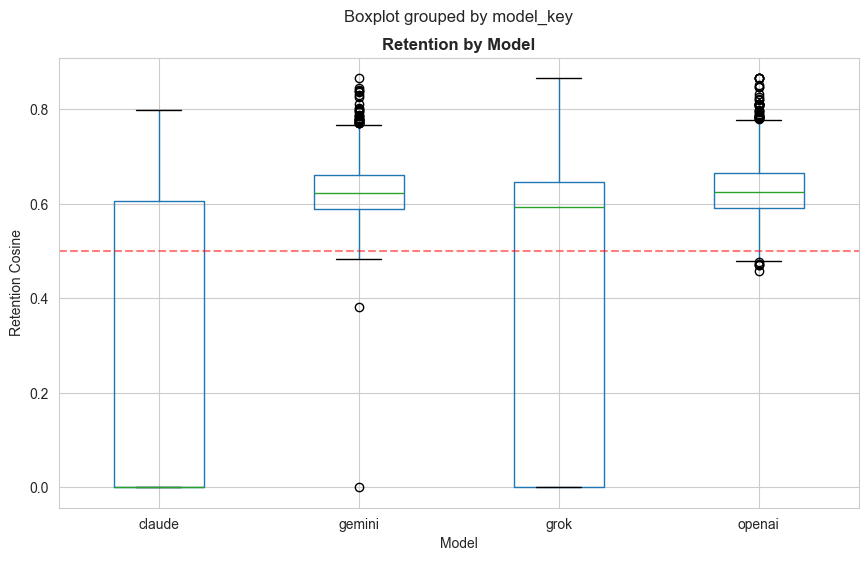

In [7]:
# Retention by model
fig, ax = plt.subplots(figsize=(10, 6))
retention.boxplot(column='retention_cosine', by='model_key', ax=ax)
ax.set_title('Retention by Model', fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Retention Cosine')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
plt.show()

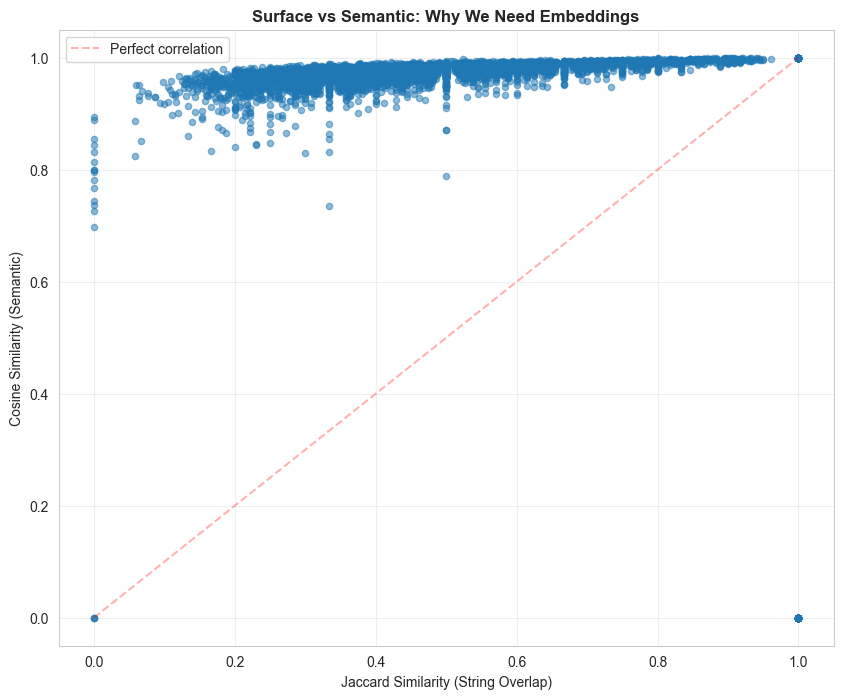

💡 Found 890 cases with high semantic (>0.8) but low Jaccard (<0.3)


In [8]:
# Surface vs semantic
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(run_stability['jaccard_norm_eval'], run_stability['cosine_similarity'], alpha=0.5, s=20)
ax.set_xlabel('Jaccard Similarity (String Overlap)')
ax.set_ylabel('Cosine Similarity (Semantic)')
ax.set_title('Surface vs Semantic: Why We Need Embeddings', fontweight='bold')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.3, label='Perfect correlation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

high_sem_low_jac = run_stability[
    (run_stability['cosine_similarity'] > 0.8) & 
    (run_stability['jaccard_norm_eval'] < 0.3)
]
print(f"💡 Found {len(high_sem_low_jac)} cases with high semantic (>0.8) but low Jaccard (<0.3)")

In [9]:
# Cost-effectiveness
print("COST-EFFECTIVENESS (Retention per dollar):")
print(compression_summary.sort_values('mean_delta_per_dollar', ascending=False))

COST-EFFECTIVENESS (Retention per dollar):
   model_key         prompt_type  n_extractions  mean_retention  \
5     gemini        short_phrase           1106        0.615943   
4     gemini             minimal           1106        0.623928   
3     gemini  anti_hallucination           1106        0.638282   
11    openai        short_phrase           1106        0.624952   
10    openai             minimal           1106        0.632480   
9     openai  anti_hallucination           1106        0.634510   
2     claude        short_phrase           1106        0.300218   
8       grok        short_phrase           1106        0.403357   
7       grok             minimal           1106        0.404365   
1     claude             minimal           1106        0.295410   
6       grok  anti_hallucination           1106        0.408551   
0     claude  anti_hallucination           1106        0.296411   

    mean_delta_retention  mean_cost  mean_tokens  mean_delta_per_dollar  \
5         

## 3. Inspect concrete examples (high semantic, low Jaccard)

This section shows *actual tags* for a few cases where cosine is high (>0.8) but Jaccard is low (<0.3). These are the “paraphrase” cases that motivate semantic evaluation.

In [10]:
import json
from glob import glob

# Load Phase 1 tables so we can show the actual tag sets for run1 vs run2
manifest = json.loads(Path("../results/phase2/phase2_manifest.json").read_text())
RUN_ID = manifest["run_id"]
RESULTS_DIR = Path("../") / manifest["results_dir"]

extraction_files = sorted(glob(str(RESULTS_DIR / f"{RUN_ID}_extractions_*.csv")))
tag_files = sorted(glob(str(RESULTS_DIR / f"{RUN_ID}_tags_*.csv")))

extractions_df = pd.concat([pd.read_csv(p) for p in extraction_files], ignore_index=True)
tags_df = pd.concat([pd.read_csv(p) for p in tag_files], ignore_index=True)

# Clean norm_eval the same way as analysis
if "tag_norm_eval" in tags_df.columns:
    tags_df["tag_norm_eval"] = tags_df["tag_norm_eval"].astype(str).map(str.strip)
    tags_df.loc[tags_df["tag_norm_eval"].isin(["", "nan", "None"]), "tag_norm_eval"] = np.nan

high_sem_low_jac = run_stability[
    (run_stability["cosine_similarity"] > 0.8) &
    (run_stability["jaccard_norm_eval"] < 0.3)
].copy()

print(f"Total high-semantic/low-Jaccard cases: {len(high_sem_low_jac)}")

# Sample a few and print the actual tag sets
sample = high_sem_low_jac.sample(n=min(5, len(high_sem_low_jac)), random_state=42)

for _, r in sample.iterrows():
    venue_id = r["venue_id"]
    model_key = r["model_key"]
    prompt_type = r["prompt_type"]

    g = extractions_df[(extractions_df["venue_id"] == venue_id) &
                      (extractions_df["model_key"] == model_key) &
                      (extractions_df["prompt_type"] == prompt_type)].sort_values("run_number")

    if len(g) < 2:
        continue

    exp1 = g.iloc[0]["exp_id"]
    exp2 = g.iloc[1]["exp_id"]

    t1 = sorted(set(tags_df.loc[tags_df["exp_id"] == exp1, "tag_norm_eval"].dropna().astype(str).map(str.strip)))
    t1 = [x for x in t1 if x]
    t2 = sorted(set(tags_df.loc[tags_df["exp_id"] == exp2, "tag_norm_eval"].dropna().astype(str).map(str.strip)))
    t2 = [x for x in t2 if x]

    s1, s2 = set(t1), set(t2)
    only1 = sorted(list(s1 - s2))
    only2 = sorted(list(s2 - s1))
    inter = sorted(list(s1 & s2))

    print("\n" + "=" * 80)
    print(f"venue_id={venue_id} model={model_key} prompt={prompt_type}")
    print(f"cosine={r['cosine_similarity']:.3f}  jaccard={r['jaccard_norm_eval']:.3f}  mmc={r['mmc']:.3f}")
    print(f"|run1|={len(t1)}  |run2|={len(t2)}  |intersection|={len(inter)}")

    print("\nShared (intersection) — first 15:")
    print(inter[:15])

    print("\nOnly in run1 — first 15:")
    print(only1[:15])

    print("\nOnly in run2 — first 15:")
    print(only2[:15])

Total high-semantic/low-Jaccard cases: 890

venue_id=GzGweVs3VP2HbVYvUmDv model=gemini prompt=short_phrase
cosine=0.964  jaccard=0.297  mmc=0.804
|run1|=16  |run2|=32  |intersection|=11

Shared (intersection) — first 15:
["chef' table", 'consistent food', 'excellent cocktail', 'hama chili', 'loud atmosphere', 'lunch special', 'menu confusion', 'mushroom nigiri', 'sushi bar seating', 'tasting menu style', 'vegan option']

Only in run1 — first 15:
['creative flavor', 'deliciou food', 'elegant ambiance', 'special occasion spot', 'top-notch service']

Only in run2 — first 15:
['calm ambiance', 'drink pairing', 'eggplant bao', 'elegant design', 'excellent service', 'expert recommendation', 'fried milk dessert', 'friendly staff', 'high-quality ingredient', 'innovative flavor', 'interactive dining', 'knowledgeable staff', 'life-changing food', 'memorable experience', 'outstanding vegan sushi']

venue_id=Ox8KIV7x6Q4fwaDpYtxD model=openai prompt=anti_hallucination
cosine=0.966  jaccard=0.286  m